In [61]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = 'retina'

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [62]:
import os
import os.path as osp

# Set the number of (emulated) host devices
num_devices = 4
os.environ['XLA_FLAGS'] = f"--xla_force_host_platform_device_count={num_devices}"

import numpy as np

import jax
import jax.numpy as jnp
from jax import lax
import gymnax
from gymnax.visualize import Visualizer
from tqdm import tqdm

jax.device_count(), jax.devices()

(4, [CpuDevice(id=0), CpuDevice(id=1), CpuDevice(id=2), CpuDevice(id=3)])

In [63]:
from functools import partial

from utils.models import get_model_ready
from utils.helpers import load_config, save_pkl_object


from src.control.dynamics import get_state,get_step_model,kinematics,get_action_space
from src.control.MPPI import MPPI_wrapper,weighting,MPPI_scores_wrapper,MPPI_control,weighting
from src.objective_fns.cost_to_go_fns import get_cost
from src.objective_fns.objectives import MPC_decorator

In [64]:
gym_env = "Pendulum-v1"

In [53]:
dynamic_rollout = jax.jit(partial(kinematics,step_fn=get_step_model(gym_env)))

mppi = MPPI_wrapper(dynamic_rollout)

mpc_obj = MPC_decorator(get_cost(gym_env),dynamic_rollout,0.99)

mppi_scores = MPPI_scores_wrapper(mpc_obj)

weight_fn = weighting()

In [93]:
class Args(object):
  def __init__(self):
    pass

args = Args()

args.num_traj = 250
args.horizon = 120
args.MPPI_iterations=100

episode_length = 150

In [94]:
random_key = jax.random.PRNGKey(123)

In [95]:
if gym_env == "CartPole-v1":
  state = jnp.array([1.5,0.04,0.02,-0.05])
if gym_env == "Pendulum-v1":
  state = jnp.array([0.93332462, -0.35903364])
  
U = jnp.array(np.random.randn(15,args.horizon,1)*0.2)
U_nominal = U.mean(axis=0)

cov = jnp.eye(args.horizon)*1.0

In [96]:
state_seq_mppi = [get_state(state,action=U_nominal[-1],time=0,env_name=gym_env)]
                  
                
rewards = [get_cost(env_name=gym_env)(state)]

pbar = tqdm(total=episode_length, desc="Starting")

for i in range(1,episode_length+1):
  (U_nominal,cov_prime), (states,states_MPPI), cost_MPPI, key = MPPI_control(state,U_nominal,cov,random_key,
              dynamic_rollout,get_action_space(gym_env),
              mppi,mppi_scores,weight_fn,
              method=None,state_train=None,
              args=args)
  
  state = states[0]
  rewards.append(get_cost(env_name=gym_env)(state))
  state_seq_mppi.append(get_state(state,action=U_nominal[-1],time=i,env_name=gym_env))

# print(U_nominal.shape)
# print("U: ",U_nominal)
  pbar.set_description(f"t: {i+1} State: {state} Action: {U_nominal[0]}")
  pbar.update(1)
  
pbar.close()

rewards = np.array(rewards)


t: 151 State: [ 0.01542589 -0.04661154] Action: [-0.30362841]: 100%|████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:44<00:00,  3.34it/s]


In [65]:
base =  osp.join("expert_agents",gym_env,"ppo")
configs = load_config(base + ".yaml")

In [66]:
env, env_params = gymnax.make(
        configs.train_config.env_name,
        **configs.train_config.env_kwargs,
    )
env_params.replace(**configs.train_config.env_params)

EnvParams(max_steps_in_episode=200, max_speed=8.0, max_torque=2.0, dt=0.05, g=10.0, m=1.0, l=1.0)


KeyboardInterrupt



Error in callback <function _draw_all_if_interactive at 0x0000022D7F7DC5E0> (for post_execute), with arguments args (),kwargs {}:


KeyboardInterrupt: 

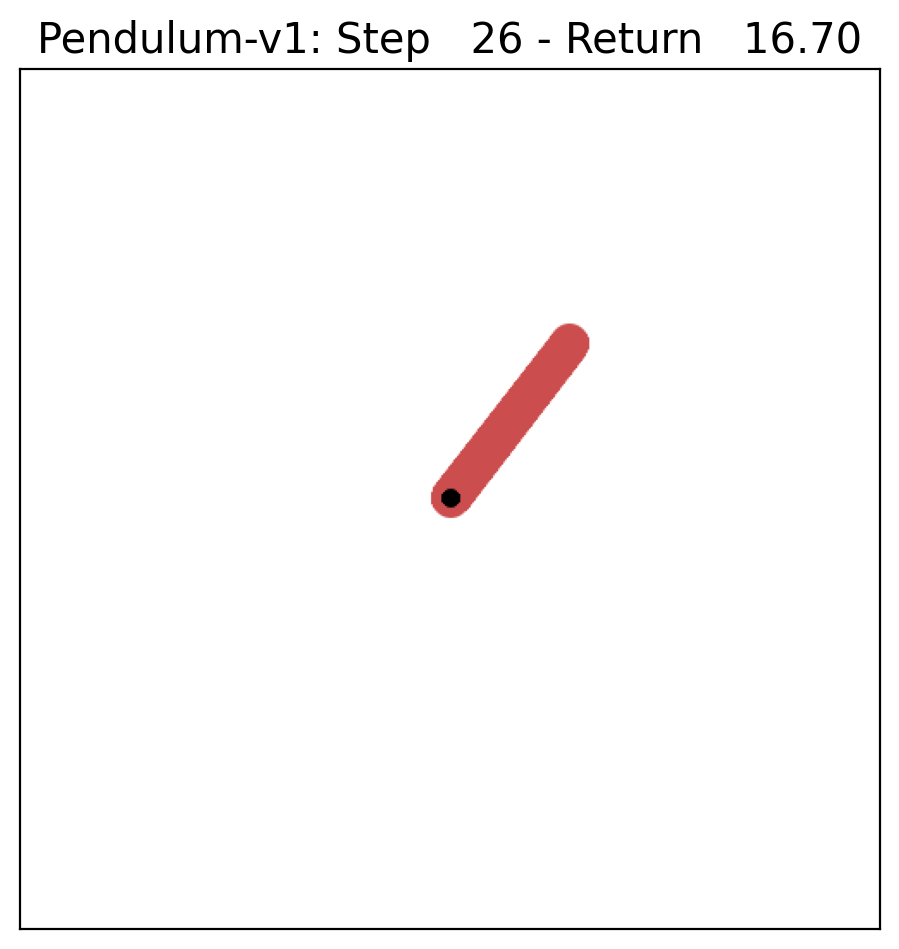

In [67]:
vis = Visualizer(env, env_params, state_seq_mppi, rewards)
vis.animate(osp.join("results",f"{gym_env}-mppi.gif"))

## Random Action Demo

In [ ]:
if gym_env == "CartPole-v1":
  state = jnp.array([1.5,0.04,0.02,-0.05])
if gym_env == "Pendulum-v1":
  state = jnp.array([0.93332462, -0.35903364])
  
U = jnp.array(np.random.randn(15,args.horizon,1)*0.2)
U_nominal = U.mean(axis=0)

cov = jnp.eye(args.horizon)*1.5

In [ ]:
state_seq_random = [get_state(state,action=U_nominal[-1],time=0,env_name=gym_env)]
rewards = [get_cost(env_name=gym_env)(state)]
pbar = tqdm(total=episode_length, desc="Starting")

for i in range(1,episode_length+1):
  action = jnp.array(np.random.randn(1,))*5
  action = jnp.clip(action,-10,10)

  
  state = get_step_model(gym_env)(action,state)
  
  rewards.append(get_cost(env_name=gym_env)(state))
  state_seq_random.append(get_state(state,action=action,time=i,env_name=gym_env))

# print(U_nominal.shape)
# print("U: ",U_nominal)
  # print("State: ",state, "Action: ",action)
  pbar.set_description(f"t: {i+1} State: {state} Action: {U_nominal[0]}")
  pbar.update(1)
  
pbar.close()

rewards = np.array(rewards)

In [ ]:
vis = Visualizer(env, env_params, state_seq_random,rewards)
vis.animate(osp.join("results",f"{gym_env}-random.gif"))

## Expert Demo

In [36]:
from utils.models import load_neural_network

In [68]:
gym_env = "Pendulum-v1"
base =  osp.join("expert_agents",gym_env,"ppo")
configs = load_config(base + ".yaml")
model, model_params = load_neural_network(
    configs.train_config, base + ".pkl"
)

Loaded data from expert_agents\Pendulum-v1\ppo.pkl.


In [72]:
episode_length = 200

In [90]:
def rollout_episode(env, env_params, model, model_params, max_frames=200):
    state_seq = []
    rng = jax.random.PRNGKey(0)

    rng, rng_reset = jax.random.split(rng)
    obs, env_state = env.reset(rng_reset, env_params)

    if gym_env == "CartPole-v1":
      obs = jnp.array([1.5,0.04,0.02,-0.05])
      env_state = get_state(obs,time=0,env_name=gym_env)


  
    if model is not None:
        if model.model_name == "LSTM":
            hidden = model.initialize_carry()

    t_counter = 0
    reward_seq = []
    while True:
        state_seq.append(env_state)
        rng, rng_act, rng_step = jax.random.split(rng, 3)

        if model.model_name.startswith("separate"):
            v, pi = model.apply(model_params, obs, rng_act)
            action = pi.sample(seed=rng_act)

        else:
            action = model.apply(model_params, obs, rng_act)

        next_obs, next_env_state, reward, done, info = env.step(
            rng_step, env_state,action, env_params
        )
      
        reward_seq.append(reward)
        print(t_counter, reward, obs, env_state.theta,action, done)
        print(10 * "=")
        t_counter += 1
        if done or t_counter == max_frames:
            break
        else:
            env_state = next_env_state
            obs = next_obs
    print(f"{env.name} - Steps: {t_counter}, Return: {np.sum(reward_seq)}")
    return state_seq, np.cumsum(reward_seq)

In [91]:
env, env_params = gymnax.make(
        configs.train_config.env_name,
        **configs.train_config.env_kwargs,
    )
env_params.replace(**configs.train_config.env_params)
state_seq, cum_rewards = rollout_episode(
    env, env_params, model, model_params,max_frames=episode_length
)

0 -5.477141025831801 [-0.69552635  0.71850059 -0.113958  ] 2.339948539557192 [0.69513696] False
1 -5.6288185333149965 [-0.71429177  0.69984803  0.52918798] 2.366407938505616 [0.96333285] False
2 -6.034767411785521 [-0.75492537  0.65581071  1.19857393] 2.4263366348861566 [2.61142046] False
3 -6.7801417530121 [-0.8163495   0.57755822  1.99043196] 2.525858233011748 [7.42808655] False
4 -7.832247760012119 [-0.88720061  0.46138388  2.72360063] 2.662038264457104 [3.78470814] False
5 -9.151290938730613 [-0.95200586  0.3060798   3.36963854] 2.830520191219843 [5.69151408] False
6 -10.673904984224027 [-0.99326651  0.11585181  3.89919839] 3.025480110584939 [-0.01668308] False
7 -10.945475805120088 [-0.99655195 -0.0829712   3.98358478] 3.2246593497779727 [10.22748864] False
8 -9.894002820224271 [-0.95705341 -0.28991164  4.22135638] 3.4357271689189868 [5.41152475] False
9 -8.785178284694428 [-0.87307107 -0.48759296  4.30392265] 3.6509233014194313 [7.71436199] False
10 -7.6583546685357335 [-0.750986

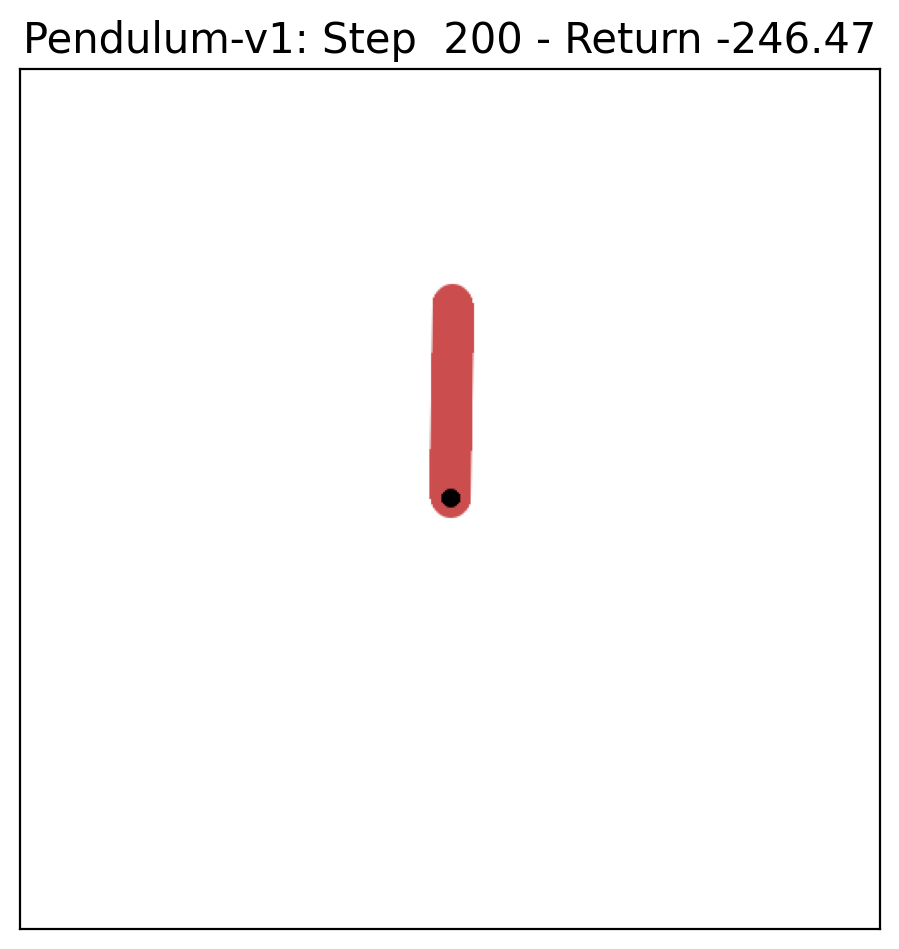

In [92]:
vis = Visualizer(env, env_params, state_seq, cum_rewards)
vis.animate(osp.join("results",f"{gym_env}-ppo.gif"))

# Debugging

In [ ]:
"""Run training with ES or PPO. Store logs and agent ckpt."""
ppo_yaml = osp.join("expert_agents","CartPole-v1","ppo.yaml")
seed_id = 123
lrate = 5e-04

config = load_config(ppo_yaml, seed_id, lrate)

rng = jax.random.PRNGKey(config.train_config.seed_id)
# Setup the model architecture
rng, rng_init = jax.random.split(rng)
model, policy_params = get_model_ready(rng_init, config.train_config)

In [ ]:
def batch_step(action, state):
    return jax.vmap(cartpole_step, in_axes=(0,0))(
        action, state)
    

In [ ]:
state = jnp.array([0.1,0.1,0.1,0.1])
action = jnp.array([-1.])

In [ ]:
state = cartpole_step(action,state)
state

In [ ]:
state_batch = [jnp.array(np.random.randn(5,)),
                       jnp.array(np.random.randn(5,)),
                       jnp.array(np.random.randn(5,)),
                       jnp.array(np.random.randn(5,))]
state_batch = jnp.stack(state_batch,axis=1)
action_batch = jnp.array(np.random.randint(0,2,5)).astype(float).reshape(-1,1)

In [ ]:
next_state  = batch_step(
   action_batch,state_batch
)
next_state

In [ ]:
state_batch = [jnp.ones(5),
                       jnp.ones(5),
                       jnp.ones(5),
                       jnp.ones(5)]
state_batch = jnp.stack(state_batch,axis=1)
action_batch = jnp.ones(5).reshape(-1,1)*-5

In [ ]:
next_state  = batch_step(
   action_batch,state_batch
)

In [ ]:
next_state

In [ ]:
# Jit-Compiled Episode Rollout
from functools import partial

jit_rollout = jax.jit(partial(kinematics,step_fn=cartpole_step))

In [ ]:
state = jnp.ones(4)*0.1
action = jnp.array(np.random.randint(0,2,10)).reshape(-1,1)
action.ravel()

In [ ]:
x_rollout = jit_rollout(action,state)

In [ ]:
x_rollout

In [ ]:
state_t =  jnp.array([0.25,.1,0.2,0.3])
action = jnp.array([15])
for t in range(10):
  state_t = cartpole_step(action,state_t)
  print(state_t)

In [ ]:
state = jnp.array([0.25,.1,0.2,0.3])
action = jnp.ones(10).reshape(-1,1)*15
x_rollout = jit_rollout(action,state)
x_rollout

In [ ]:
cartpole_dynamics = jax.vmap(jit_rollout,in_axes=(0,None))

action = jnp.ones((10,5,1))*15

cartpole_dynamics(action,state)